## TRANSPORTS

plots transports through JDF in mol/m2/s, daily, figures in ./FLUX_plot

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
from __future__ import print_function
from numpy import *
from scipy import *
import netCDF4 as nc
import numpy as np
import scipy as sp
import seawater
import datetime as dt

""
from salishsea_tools import (
    nc_tools,
    viz_tools, 
    geo_tools,
    tidetools
)
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc

import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')
import mocsy
import river_201702 as rv
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
import arrow
import gsw
import datetime as dt

%matplotlib inline

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
def make_nclen_hindcast(start,end,ftype, sdir):
    date_ar = []
    sens_ar = []
    doy_ar = []
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        dddd = tdate.format('DDDD')
        nc_sens = f"/results/SalishSea/hindcast.201812/{ddmmmyy}/*1d*{ymd}*{ftype}.nc"
        tnc_sens = glob.glob(nc_sens)
        sens_ar.append(tnc_sens[0])
        date_ar.append(ddmmmyy)
        doy_ar.append(dddd)
    return date_ar, sens_ar, doy_ar

In [5]:
start = '2015-01-01'
end = '2015-12-31'

st = dt.datetime(2015,1,1)
en = dt.datetime(2015,12,31)

y_st = st.timetuple().tm_yday
print(y_st)
y_en = en.timetuple().tm_yday
print(y_en)
ts_BR = np.arange(y_st,y_en+1,1)

sdir_br = '/data/tjarniko/results/BR_2nd_2015_cop/SKOG_2/ncs'
sdir_hc = '/results/SalishSea/hindcast.201812/*15/'

dates_hc, files_hc_dian, doy_hc = make_nclen_hindcast(start,end,'grid_U', sdir_hc)
dates_hc, files_hc_grid, doy_hc = make_nclen_hindcast(start,end,'grid_T', sdir_hc)



1
365


In [6]:
t_testU_BR = nc.Dataset(files_hc_dian[0])
UVEL = t_testU_BR['vozocrtx']
UVEL_jdfmouth_BR = UVEL[:,:,:,20]
UVEL_jdfmouth2d_BR = np.squeeze(UVEL_jdfmouth_BR)

depth_bounds = t_testU_BR['depthu_bounds']
depth_cell = np.zeros(40)
depth_cell[:] = depth_bounds[:,1]-depth_bounds[:,0]
area_cells_all = np.zeros_like(UVEL_jdfmouth2d_BR)
area_cell = depth_cell*440
for i in range(0,898):
    area_cells_all[:,i] = area_cell
zlevels = t_testU_BR.variables['depthu']

VOL_transports = area_cells_all * UVEL_jdfmouth2d_BR


then run bash mov5.sh ./FLUX_plot/ FLUXDIFF_2NDYR_

In [7]:
sample_dates = np.arange(15,360,30)

In [8]:
VOLtrans_stor = np.zeros([12, 40, 898])
rho_stor = np.zeros([12, 40, 898])

for d in range(0,len(sample_dates)):
    t_sample = sample_dates[d]
    doy = doy_hc[t_sample]
    tdate = dates_hc[t_sample]

    t_testU_BR = nc.Dataset(files_hc_dian[t_sample])
    UVEL = t_testU_BR['vozocrtx']
    UVEL_jdfmouth_BR = UVEL[:,:,:,20]
    UVEL_jdfmouth2d_BR = np.squeeze(UVEL_jdfmouth_BR)

    depth_bounds = t_testU_BR['depthu_bounds']
    VOL_transports = area_cells_all * UVEL_jdfmouth2d_BR
    
    t_grid_BR = nc.Dataset(files_hc_grid[t_sample])
    S = t_grid_BR['vosaline']
    T = t_grid_BR['votemper']
    S_jdfmouth_BR = np.squeeze(S[:,:,:,20])
    T_jdfmouth_BR = np.squeeze(T[:,:,:,20])

    p_ref = 10.1325
    rho_jdfmouth_BR = gsw.rho(S_jdfmouth_BR,T_jdfmouth_BR,p_ref)
    rho_jdfmouth_BR_real = rho_jdfmouth_BR - 1000

    VOLtrans_stor[d,:,:] = VOL_transports
    rho_stor[d,:,:] = rho_jdfmouth_BR_real
    


In [9]:
np.shape(VOLtrans_stor)
np.max(VOLtrans_stor)

11850.244140625

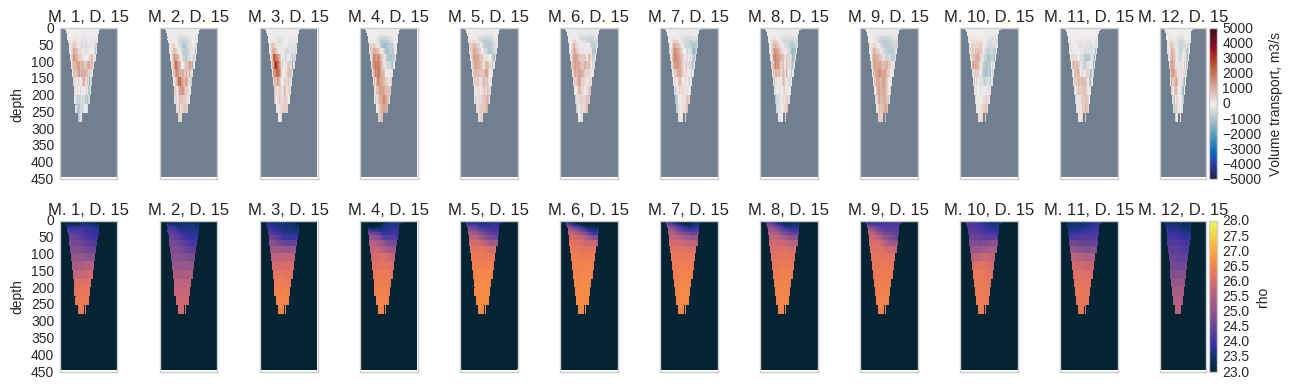

In [10]:
    fig = plt.figure(figsize=(13,4))

    for i in range(1,13):
        ax = fig.add_subplot(2,12,i)
        section_slice = np.arange(360, 460)
        
        sd = VOLtrans_stor[i-1,:,360:460]
        #sd = (rho_jdfmouth_BR_real[:,360:460])
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt, cmap = tcmap, vmin=-5000, vmax=5000 )
        if i == 12:
            cbar = fig.colorbar(mesh, ax=ax)
            cbar.set_label('Volume transport, m3/s')
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('M. '+str(i) +', D. 15') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        if i == 1:
            ax.set_ylabel('depth')
        if i != 1:
            ax.set_ylabel('')
        ax.set_xticklabels([])
        if i != 1:
            ax.set_yticklabels([])
        
    for i in range(13,25):
        ax = fig.add_subplot(2,12,i)
        section_slice = np.arange(360, 460)
        
        sd = (rho_stor[i-13,:,360:460])
        #sd = (rho_jdfmouth_BR_real[:,360:460])
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.thermal
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt, cmap = tcmap, vmin=23, vmax=28 )
        if i == 24:
            cbar = fig.colorbar(mesh, ax=ax)
            cbar.set_label('rho')
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('M. '+str(i-12) +', D. 15') 
        if i == 13:
            ax.set_ylabel('depth')
            
        ax.set_xticklabels([])
        if i != 13:
            ax.set_yticklabels([])

    #plt.suptitle('Jan 1, 2016, DIC transport and rho', fontsize = 20)
    fig.tight_layout()
    fname = './monthly_transport_rho.png'
    fig.savefig(fname)
        #plt.close()
    plt.show()

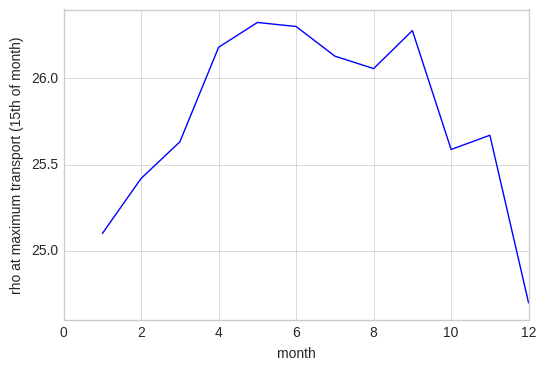

In [11]:
max_trans = np.zeros(12)
corresp_rho = np.zeros(12)
months = np.arange(1,13,1)

for i in range(0,12):
    trans = VOLtrans_stor[i,:,360:460]
    rho = rho_stor[i,:,360:460]
    maxtrans = np.max(trans)
    indx, indy = np.where(trans == maxtrans)
    corresp_rho[i] = rho[indx,indy]
    
plt.plot(months,corresp_rho)
plt.xlabel('month')
plt.ylabel('rho at maximum transport (15th of month)')

In [ ]:
avg_rhos = np.zeros(365)
for i in range(0,365):
    if i%20==0:
        print(i)
    t_sample = sample_dates[d]
    doy = doy_hc[i]
    tdate = dates_hc[i]

    t_testU_BR = nc.Dataset(files_hc_dian[i])
    UVEL = t_testU_BR['vozocrtx']
    UVEL_jdfmouth_BR = UVEL[:,:,:,20]
    UVEL_jdfmouth2d_BR = np.squeeze(UVEL_jdfmouth_BR)

    depth_bounds = t_testU_BR['depthu_bounds']
    VOL_transports = area_cells_all * UVEL_jdfmouth2d_BR

    t_grid_BR = nc.Dataset(files_hc_grid[i])
    S = t_grid_BR['vosaline']
    T = t_grid_BR['votemper']
    S_jdfmouth_BR = np.squeeze(S[:,:,:,20])
    T_jdfmouth_BR = np.squeeze(T[:,:,:,20])

    p_ref = 10.1325
    rho_jdfmouth_BR = gsw.rho(S_jdfmouth_BR,T_jdfmouth_BR,p_ref)
    rho_jdfmouth_BR_real = rho_jdfmouth_BR - 1000

    pos_trans_mask = np.zeros_like(VOL_transports)
    pos_trans_mask[VOL_transports>0] = 1
    pos_trans = VOL_transports * pos_trans_mask
    tot_trans = np.sum(np.sum(pos_trans))

    frac_trans = pos_trans/tot_trans
    frac_trans_rho = np.multiply(frac_trans,rho_jdfmouth_BR_real)
    avg_rho = np.sum(np.sum(frac_trans_rho))
    avg_rhos[i] = avg_rho

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340


$\sum_{Gridcells(Transport >0)} \frac{Transport_{Gridcell}}{Transport_{Total}}  \rho_{Gridcell}$ 

In [20]:
plt.plot(avg_rhos)
plt.title('Transport-Weighted Average rho of all gridcells with positive trasport in JdF, hindcast 201812')

[[  0.  20.]
 [  0.   0.]]
